# 로지스틱 회귀로 와인 분류하기

In [2]:
import pandas as pd
wine = pd.read_csv('data/wine.csv')
wine.head()

,alcohol,sugar,pH,class
0,9.4,1.9,3.51,0.0
1,9.8,2.6,3.20,0.0
2,9.8,2.3,3.26,0.0
3,9.8,1.9,3.16,0.0
4,9.4,1.9,3.51,0.0


In [3]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   alcohol  6497 non-null   float64
 1   sugar    6497 non-null   float64
 2   pH       6497 non-null   float64
 3   class    6497 non-null   float64
dtypes: float64(4)
memory usage: 203.2 KB


In [4]:
# class 의 종류
wine['class'].unique()

array([0., 1.])

> 0 : Red Wine , 1 : White Wine 

In [5]:
# 기본 통계량
wine.describe()
# sugar가 값들이 차이가 많이 난다

,alcohol,sugar,pH,class
count,6497.000000,6497.000000,6497.000000,6497.000000
mean,10.491801,5.443235,3.218501,0.753886
std,1.192712,4.757804,0.160787,0.430779
min,8.000000,0.600000,2.720000,0.000000
25%,9.500000,1.800000,3.110000,1.000000
50%,10.300000,3.000000,3.210000,1.000000
75%,11.300000,8.100000,3.320000,1.000000
max,14.900000,65.800000,4.010000,1.000000


In [6]:
# Dimension
wine.shape

(6497, 4)

---
# Feature와 Target으로 Data 분리

In [7]:
data = wine[['alcohol', 'sugar','pH' ]].to_numpy()
target = wine['class'].to_numpy()

### Train과 Test 분리

In [8]:
from sklearn.model_selection import train_test_split
train_input , test_input , train_target , test_target = train_test_split(data, target, test_size=0.2 , random_state=42)

In [9]:
# Train 과 Test 확인
print("Train :",train_input.shape)
print("Test :",test_input.shape)

Train : (5197, 3)
Test : (1300, 3)


### 정규화 하기 (로지스틱 회귀 이므로)

In [10]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(train_input)

train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

### 로지스틱 회귀모델 실행

In [11]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(train_scaled , train_target)

print("Train score :" , lr.score(train_scaled , train_target))
print("Test score :" , lr.score(test_scaled , test_target))

Train score : 0.7808350971714451
Test score : 0.7776923076923077


In [12]:
# 가중치와 편차 W , b
print(lr.coef_ , lr.intercept_)


[[ 0.51270274  1.6733911  -0.68767781]] [1.81777902]


class = 0.51270274 * alcohol + 1.6733911 * sugar + (-0.68767781)* pH + 1.81777902

---
### 결정트리 (DecisionTree)
회귀식은 pH로인해 음수가 나올수 있다 -> 결정트리는 크고 작냐로 결정되기때문에 -값이 나올수없다!     
어떤 때 사용하는지를 아는게 중요하다. 전처리 과정이 필요없다.

In [13]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(train_scaled, train_target)

print(dt.score(train_scaled, train_target))
print(dt.score(test_scaled, test_target))
# 과대적합의 모습을 보인다.
# 결정트리는 기본적으로 과대적합의 모습을 보인다 이를 해결하기 위한게 앙상블이다.

0.996921300750433
0.8592307692307692


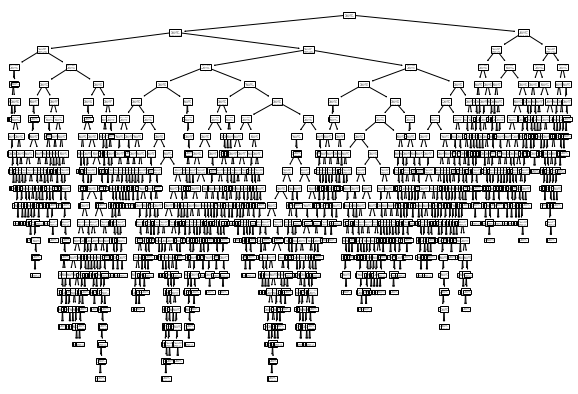

In [14]:
# 시각화
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(10,7))
plot_tree(dt)
plt.show()

> 맨 위의 단계를 root node로 하고 마지막 단계는 leaf node라고 합니다.   
> 시간이 많이 걸리고 단계가 너무 복잡하다.  

--> 단순하게 하자! 규제를 준다. 가지치기 한다.

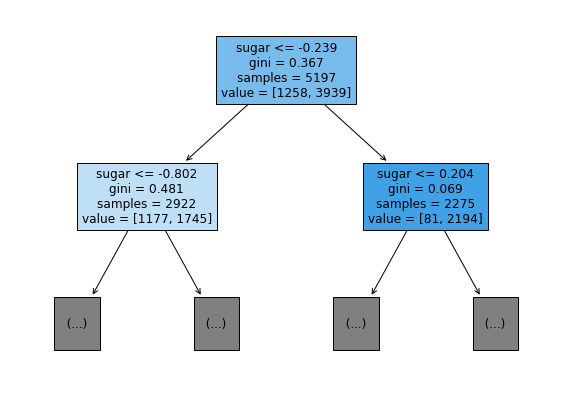

In [15]:
# decision tree의 단계(depth)를 단순하게 하자
plt.figure(figsize =(10,7))
plot_tree(dt , max_depth= 1 , filled= True , feature_names=['alcohol','sugar','pH']) 
# filled (색 채우기) : blue (class 1) ~ orange (class 0)
plt.show()

### 지니 불순도 (Gini impurity)
- 지니 불순도가 0이 나올때를 순수노드라고 한다.
- 리프노드가 순수노드인것 좋으나 이때문에 과대적합이 발생한다.
- 따라서 적정한 max_depth를 찾는것이 중요하다. 

# 가지치기(Tree Pruning)
- max_depth의 parameter 값을 조절
- decision tree에서 과대적합을 막는다.
- 규제를 써야 하는데, L1규제, L2규제를 사용할 수는 없다(얘들은 회귀식 규제)

In [16]:
dt = DecisionTreeClassifier(random_state=42 , max_depth=3)
dt.fit(train_scaled, train_target)

print(dt.score(train_scaled, train_target))
print(dt.score(test_scaled, test_target))

0.8454877814123533
0.8415384615384616


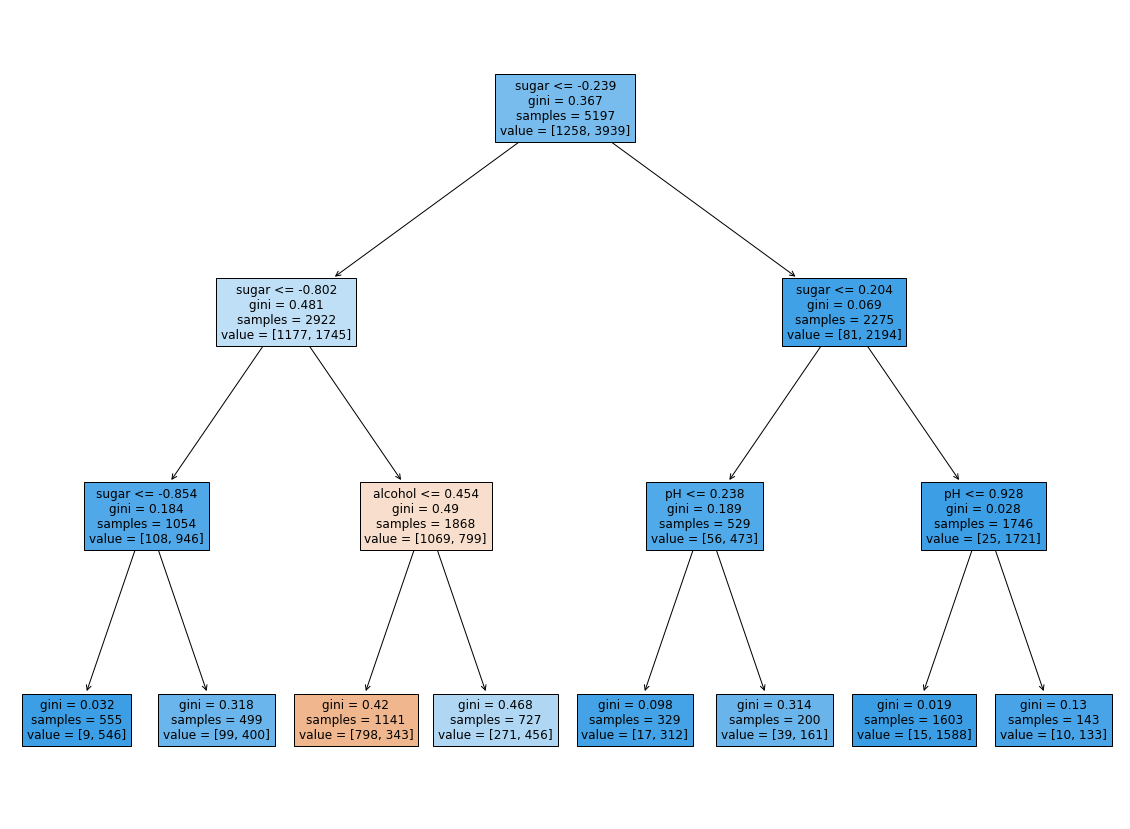

In [19]:
# 시각화
plt.figure(figsize=(20,15))
plot_tree(dt , filled= True , feature_names=['alcohol','sugar','pH'])
plt.show()

In [22]:
# 특성 중요도
dt.feature_importances_ # 슈거가 제일 중요하다


array([0.12345626, 0.86862934, 0.0079144 ])

---
### 최적화시키기

0.9087935347315759
0.8638461538461538


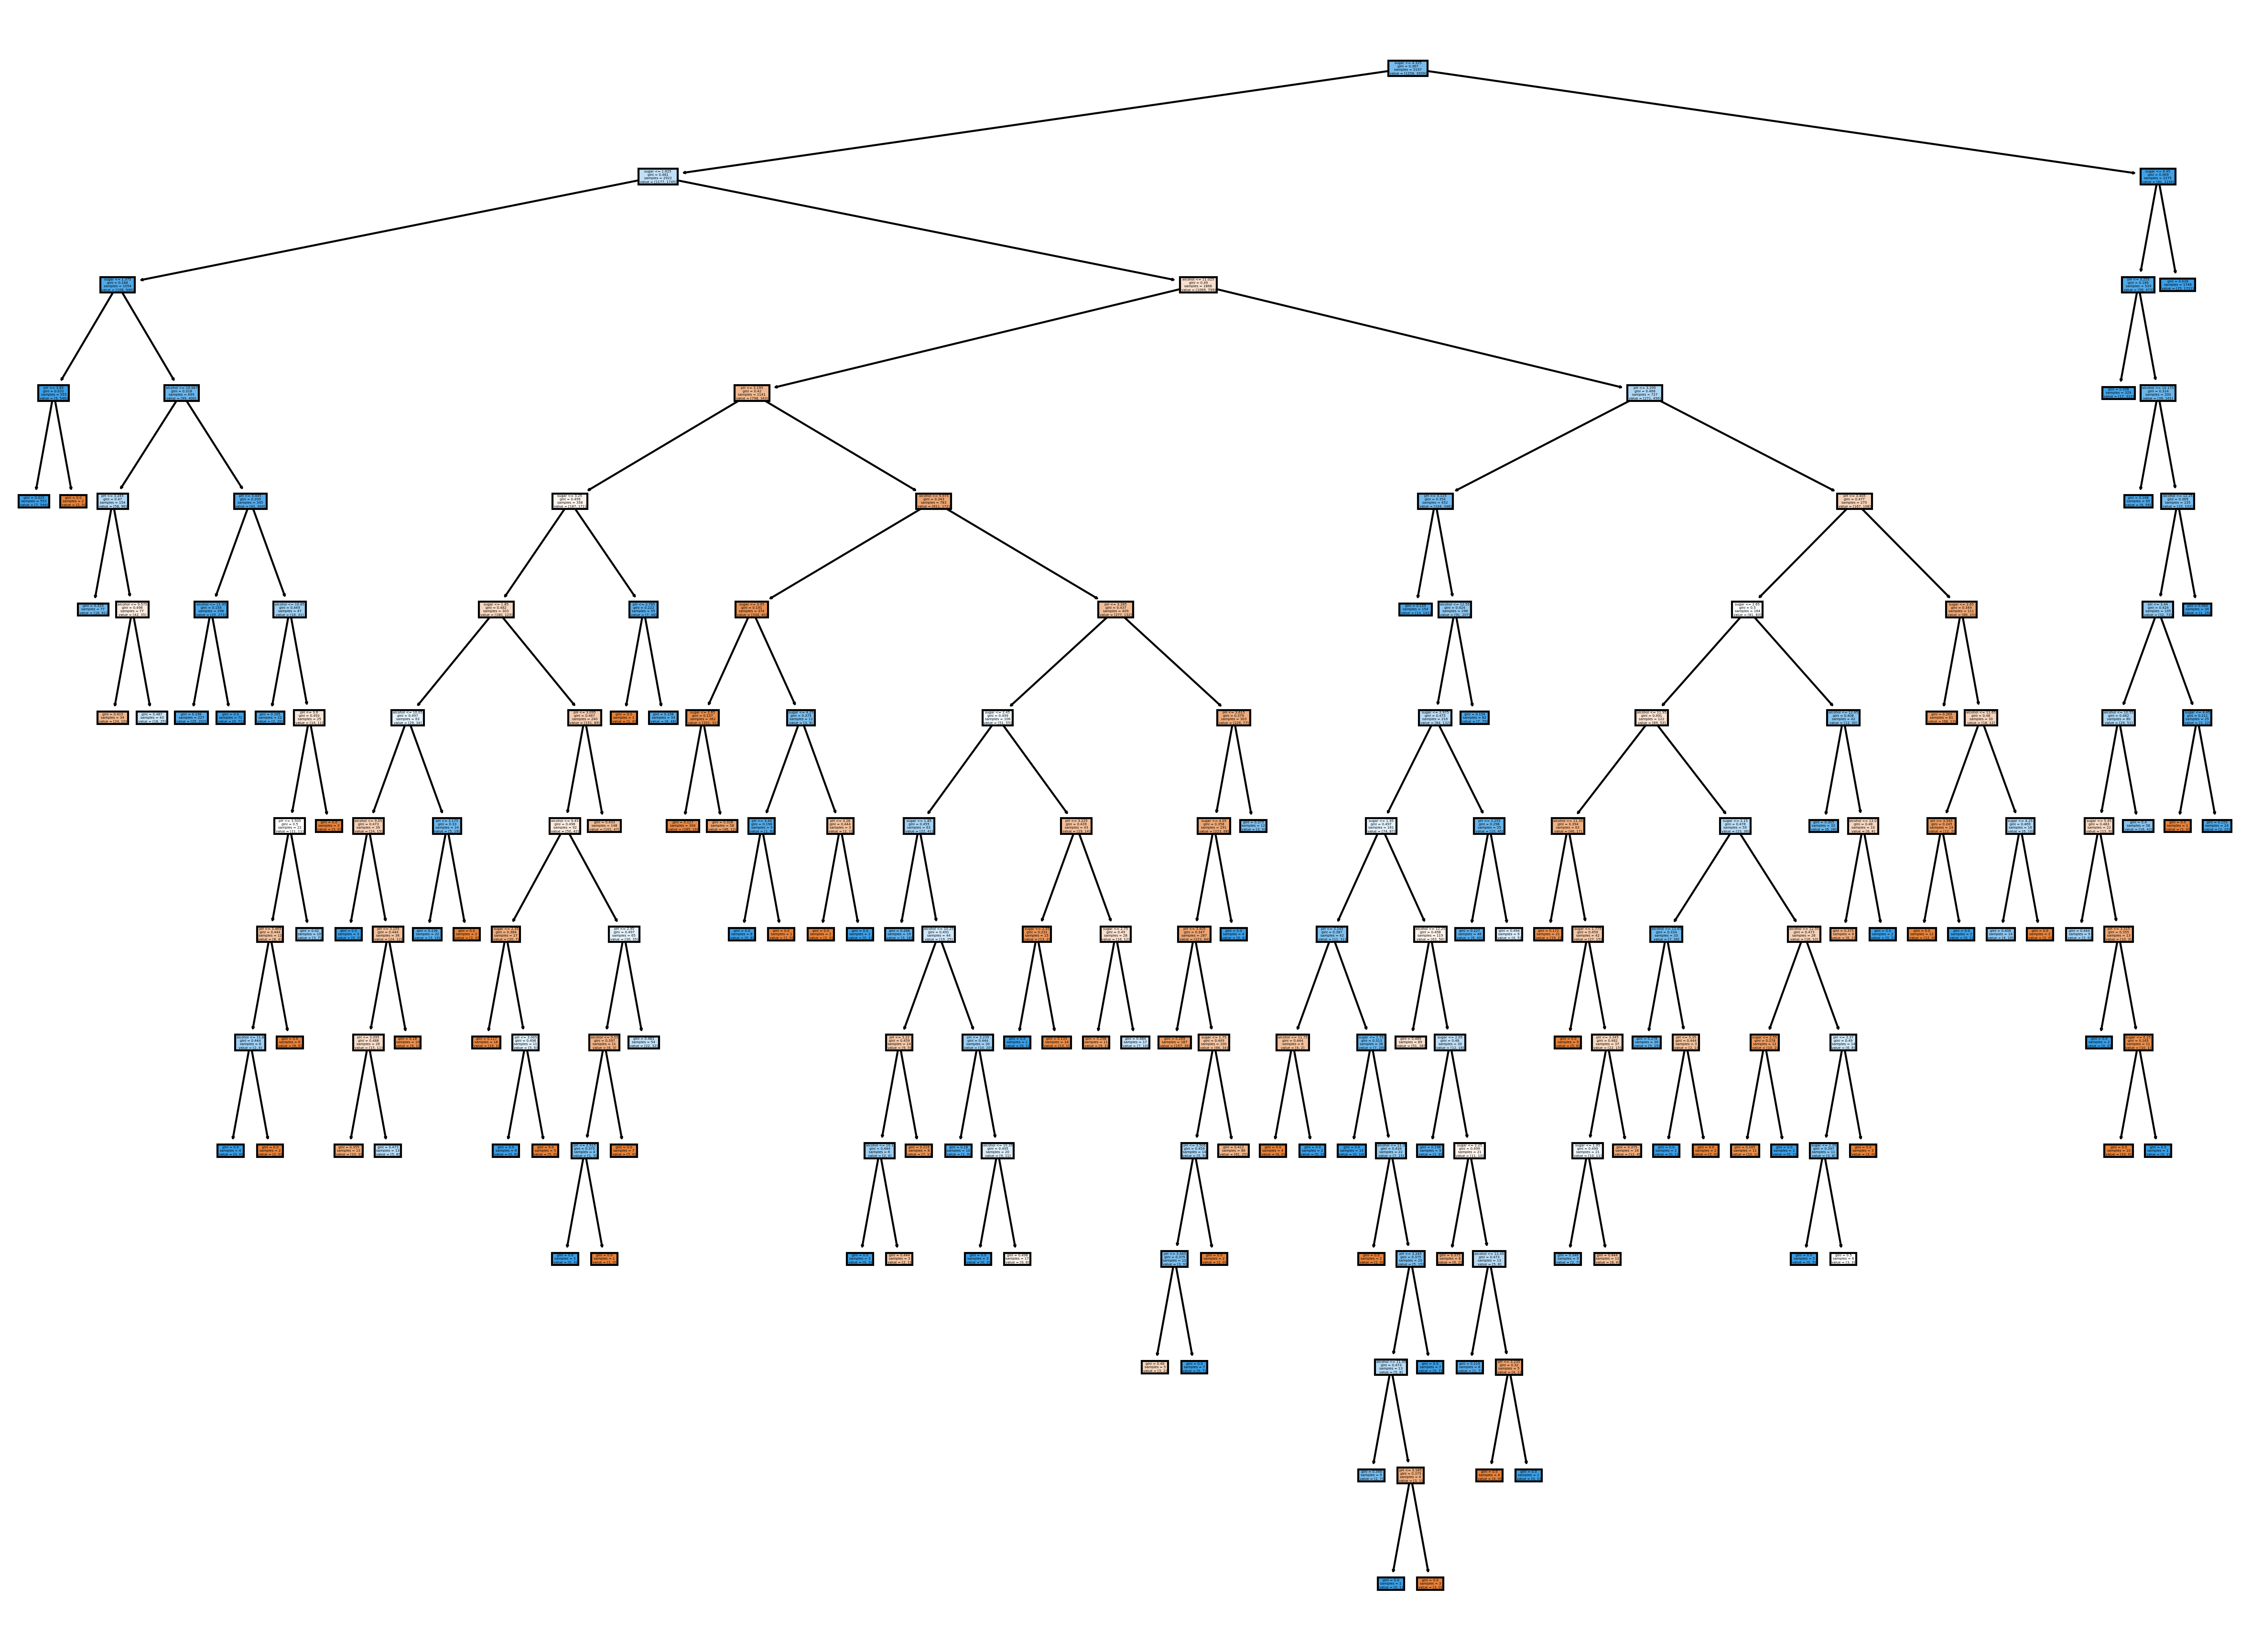

In [27]:
dt = DecisionTreeClassifier(min_impurity_decrease=0.00025, random_state=42)
# gini가 0.0005가 되면 끝내자

dt.fit(train_input, train_target)

print(dt.score(train_input, train_target))
print(dt.score(test_input, test_target))
# 시각화하기
plt.figure(figsize=(20,15), dpi=300) # dpi는 해상도
plot_tree(dt , filled= True , feature_names=['alcohol','sugar','pH'])
plt.show()

In [23]:
dt = DecisionTreeClassifier(min_impurity_decrease=0.0005, random_state=42)
# gini가 0.0005가 되면 끝내자

dt.fit(train_input, train_target)

print(dt.score(train_input, train_target))
print(dt.score(test_input, test_target))

0.8874350586877044
0.8615384615384616


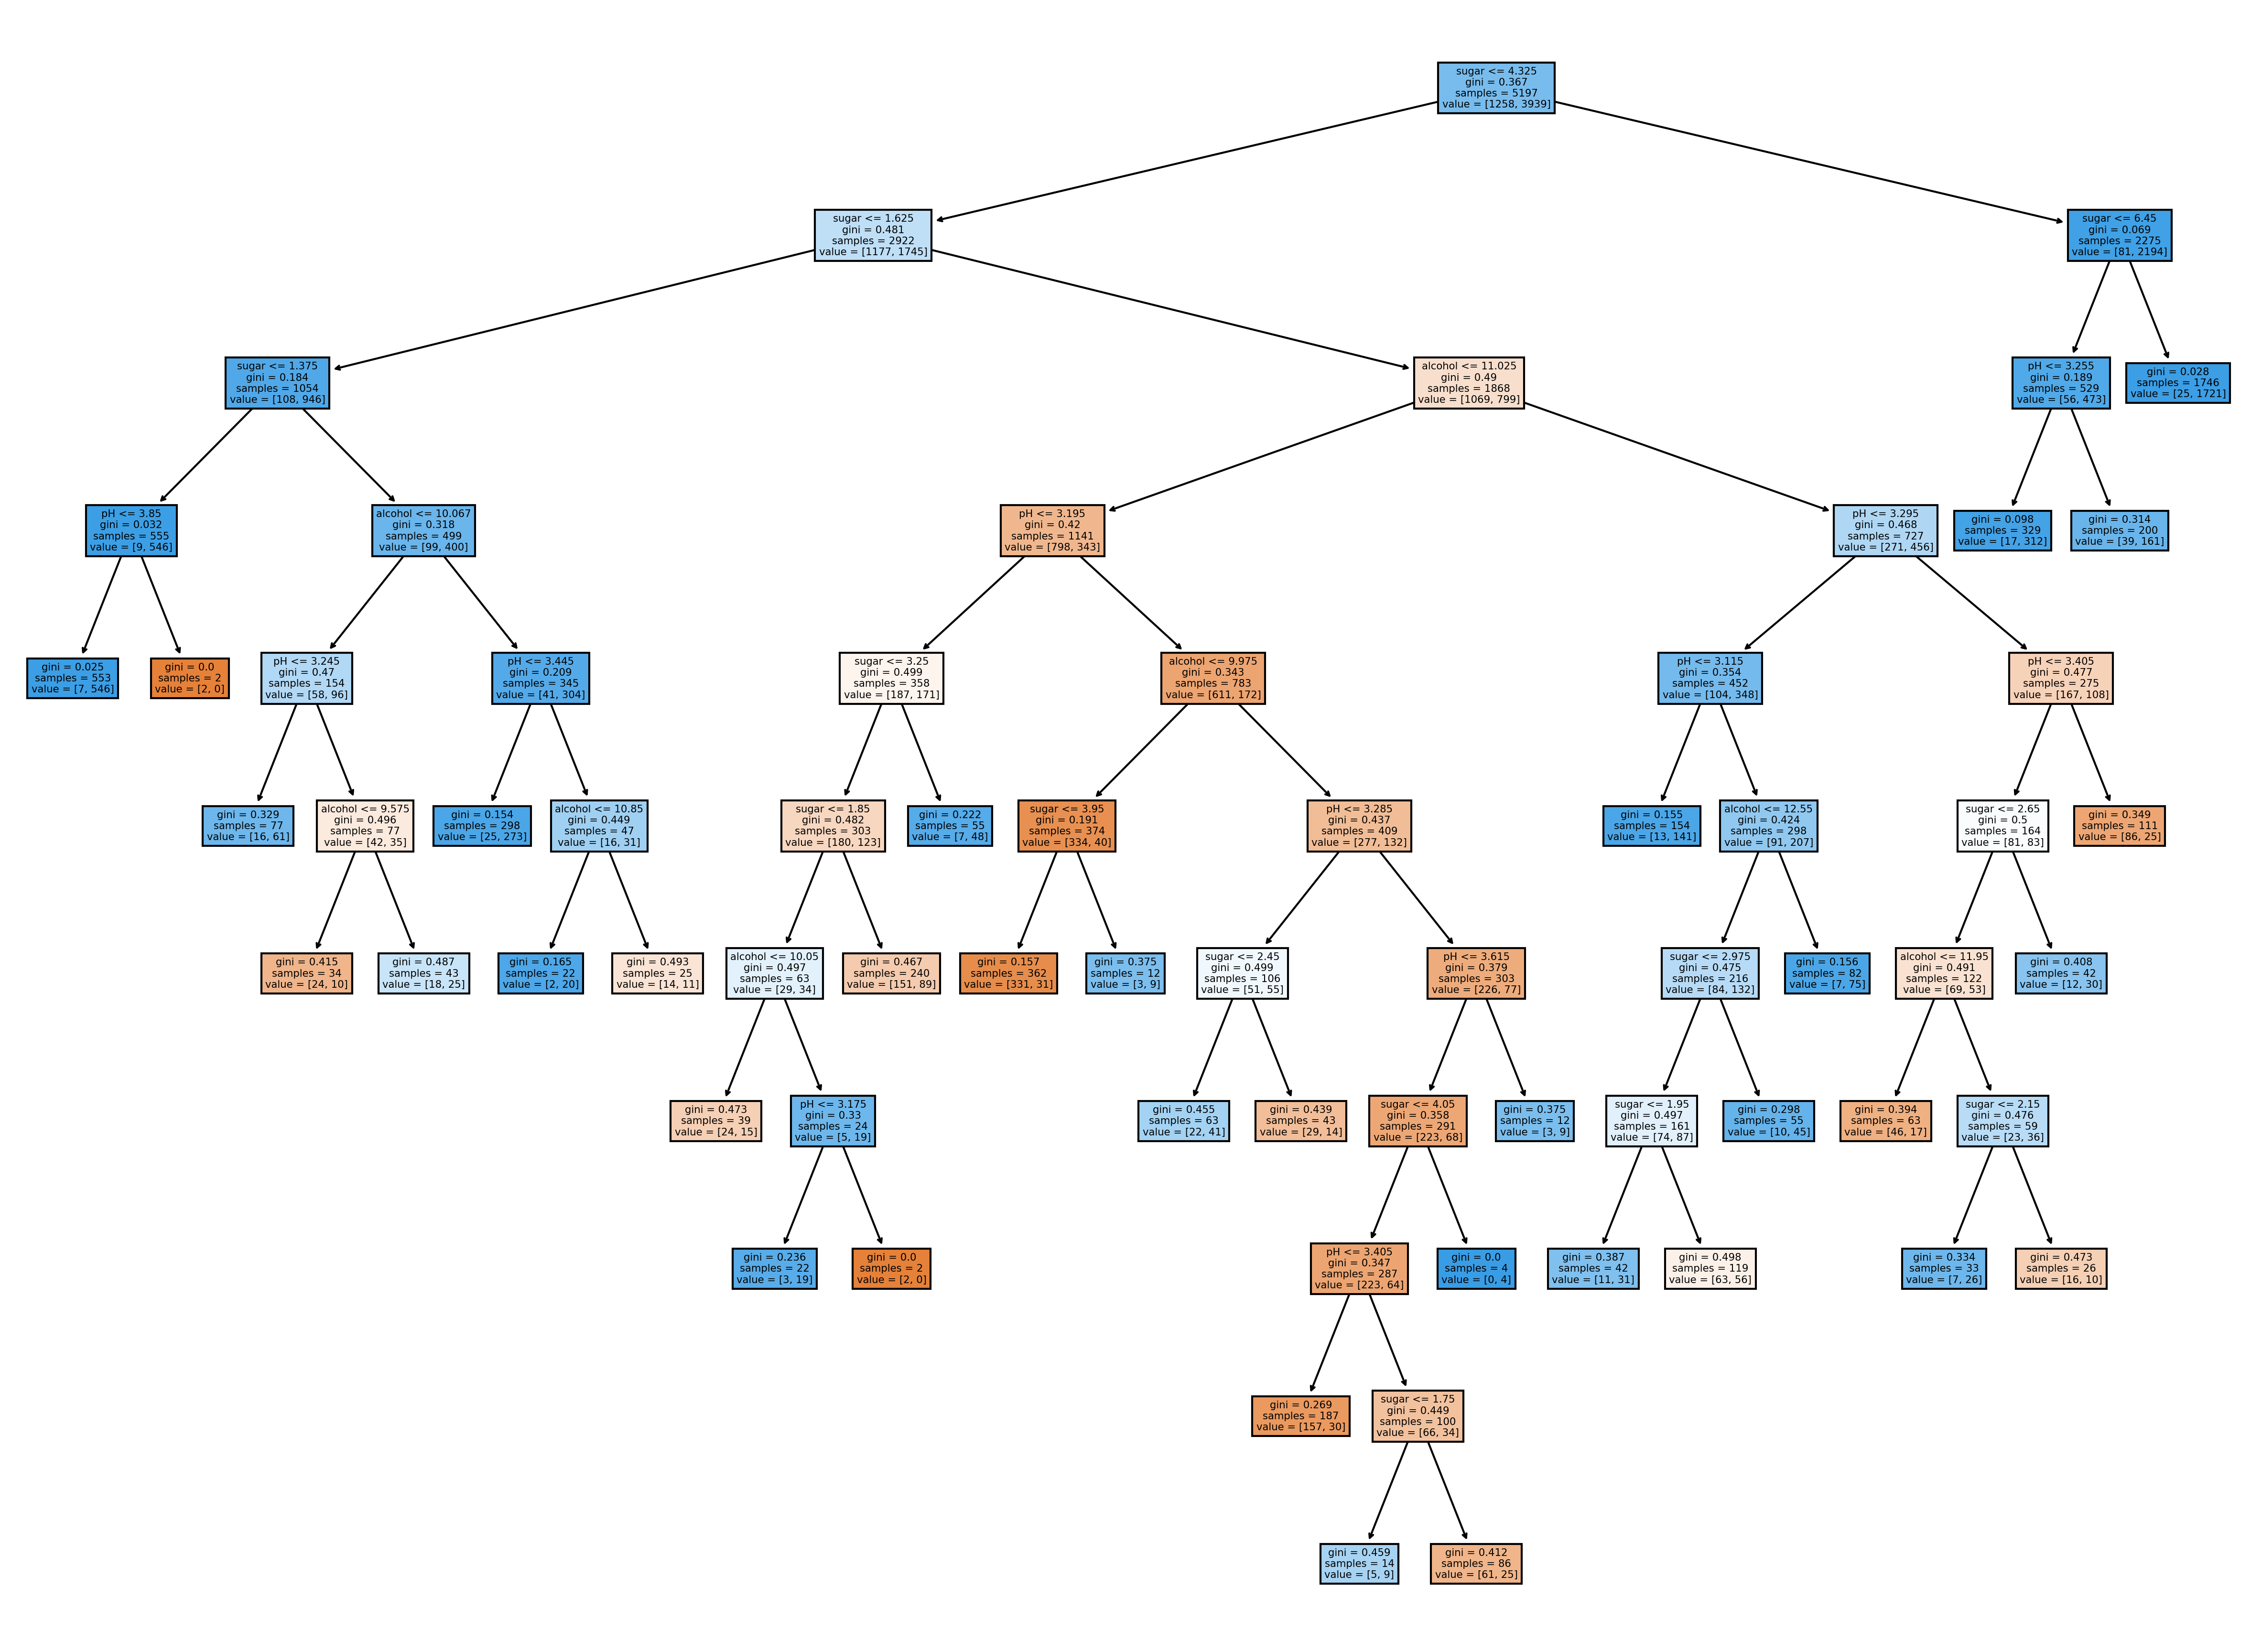

In [25]:
# 시각화하기
plt.figure(figsize=(20,15), dpi=300) # dpi는 해상도
plot_tree(dt , filled= True , feature_names=['alcohol','sugar','pH'])
plt.show()